# Death Statistics and the frailty index 
## By Gavin Qu, May 28th


1. Load the death data from xhhrel.dta file.
2. Map the death waves to the corresponding frailty columns.
3. Update the frailty index for individuals who have died in a given wave to 1.

In [48]:
import pandas as pd
import os

# Define file paths
base_dir = '/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls'
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'

# Load the cleaned combined data
cleaned_combined_data = pd.read_stata(cleaned_combined_data_path)

# Load the death information from xhhrel.dta
death_file_path = os.path.join(base_dir, 'xhhrel.dta')
death_data = pd.read_stata(death_file_path, convert_categoricals=False)

# Extract the pidp and dcsedw_dv (death wave)
death_data = death_data[['pidp', 'dcsedw_dv']]

# Map death wave values to corresponding wave prefixes
death_wave_map = {
    20: 'b', 21: 'c', 22: 'd', 23: 'e', 24: 'f', 25: 'g',
    26: 'h', 27: 'i', 28: 'j', 29: 'k', 30: 'l', 31: 'm'
}

# Function to filter individuals aged 20 and above
def filter_age_range(df, age_start, wave_prefixes):
    age_columns = [f'{prefix}_age_dv' for prefix in wave_prefixes]
    filtered_dfs = []
    for i, age_column in enumerate(age_columns):
        if age_column in df.columns:
            age_data = df[['pidp', age_column]].copy()
            age_data.rename(columns={age_column: 'age'}, inplace=True)
            age_data['wave'] = wave_prefixes[i]
            age_data['age'] += i  # Add years for subsequent waves
            filtered_dfs.append(age_data[age_data['age'] >= age_start])
    return pd.concat(filtered_dfs, ignore_index=True)

# Function to calculate the frailty index for each wave
def calculate_frailty_index(df, wave_prefixes):
    total_deficits = 28
    for prefix in wave_prefixes:
        hcond_columns = [f'{prefix}_hcond{i}' for i in range(1, 18)]
        disdif_columns = [f'{prefix}_disdif{i}' for i in range(1, 12)]
        relevant_columns = hcond_columns + disdif_columns
        
        # Check for the existence of columns and replace missing ones with 0
        for col in relevant_columns:
            if col not in df.columns:
                df[col] = 0

        # Calculate the frailty index as the ratio of 1s in the relevant columns to the total number of deficits
        df[f'{prefix}_frailty'] = df[relevant_columns].apply(lambda x: (x == 1).sum(), axis=1) / total_deficits

        # Round the frailty index to 5 decimal places
        df[f'{prefix}_frailty'] = df[f'{prefix}_frailty'].round(5)
        
    return df

# Define wave prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Filter individuals aged 20 and above
filtered_data = filter_age_range(cleaned_combined_data, 20, wave_prefixes)

# Merge filtered data with the original cleaned data to get other variables
merged_data = pd.merge(filtered_data, cleaned_combined_data, on=['pidp', 'wave'])

# Calculate the frailty index for each wave
frailty_data = calculate_frailty_index(merged_data, wave_prefixes)

# Update the frailty index for deceased individuals
for wave_value, wave_prefix in death_wave_map.items():
    death_pids = death_data[death_data['dcsedw_dv'] == wave_value]['pidp']
    frailty_data.loc[frailty_data['pidp'].isin(death_pids), f'{wave_prefix}_frailty'] = 1

# Display the first few rows of the frailty data
print("Frailty Data Head:")
print(frailty_data[[col for col in frailty_data.columns if 'frailty' in col]].head())

# Save the frailty index data to a Stata file
frailty_data.to_stata(frailty_index_path, write_index=False)

print(f"Frailty index data saved to {frailty_index_path}")


Frailty Data Head:
   a_frailty  b_frailty  c_frailty  d_frailty  e_frailty  f_frailty  \
0    0.03571        0.0        0.0        0.0        0.0        0.0   
1    0.00000        0.0        0.0        0.0        0.0        0.0   
2    0.03571        0.0        0.0        0.0        0.0        0.0   
3    0.25000        0.0        0.0        0.0        0.0        0.0   
4    0.07143        0.0        0.0        0.0        0.0        0.0   

   g_frailty  h_frailty  i_frailty  j_frailty  k_frailty  l_frailty  m_frailty  
0        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
1        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
2        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
3        0.0        0.0        0.0        1.0        0.0        0.0        0.0  
4        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
Frailty index data saved to /Users/gavinqu/Desktop/School/Dissertati

In [49]:
import pandas as pd

# Load the frailty index data
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'
frailty_data = pd.read_stata(frailty_index_path)

# Define wave prefixes and age column prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]
age_columns = [f'{prefix}_age_dv' for prefix in wave_prefixes]

# Function to get the range of frailty index values
def get_frailty_range(df, wave_prefixes):
    frailty_ranges = {}
    for prefix in wave_prefixes:
        frailty_col = f'{prefix}_frailty'
        if frailty_col in df.columns:
            frailty_min = df[frailty_col].min()
            frailty_max = df[frailty_col].max()
            frailty_ranges[prefix] = (frailty_min, frailty_max)
    return frailty_ranges

# Function to get the range of age values
def get_age_range(df, wave_prefixes):
    age_ranges = {}
    for prefix in wave_prefixes:
        age_col = f'{prefix}_age_dv'
        if age_col in df.columns:
            age_min = df[age_col].min()
            age_max = df[age_col].max()
            age_ranges[prefix] = (age_min, age_max)
    return age_ranges

# Get frailty index ranges
frailty_ranges = get_frailty_range(frailty_data, wave_prefixes)

# Get age ranges
age_ranges = get_age_range(frailty_data, wave_prefixes)

# Display the results
print("Frailty Index Ranges by Wave:")
for wave, (min_val, max_val) in frailty_ranges.items():
    print(f"Wave {wave}: Min Frailty Index = {min_val}, Max Frailty Index = {max_val}")

print("\nAge Ranges by Wave:")
for wave, (min_age, max_age) in age_ranges.items():
    print(f"Wave {wave}: Min Age = {min_age}, Max Age = {max_age}")


Frailty Index Ranges by Wave:
Wave a: Min Frailty Index = 0.0, Max Frailty Index = 0.67857
Wave b: Min Frailty Index = 0.0, Max Frailty Index = 1.0
Wave c: Min Frailty Index = 0.0, Max Frailty Index = 1.0
Wave d: Min Frailty Index = 0.0, Max Frailty Index = 1.0
Wave e: Min Frailty Index = 0.0, Max Frailty Index = 1.0
Wave f: Min Frailty Index = 0.0, Max Frailty Index = 1.0
Wave g: Min Frailty Index = 0.0, Max Frailty Index = 1.0
Wave h: Min Frailty Index = 0.0, Max Frailty Index = 1.0
Wave i: Min Frailty Index = 0.0, Max Frailty Index = 1.0
Wave j: Min Frailty Index = 0.0, Max Frailty Index = 1.0
Wave k: Min Frailty Index = 0.0, Max Frailty Index = 1.0
Wave l: Min Frailty Index = 0.0, Max Frailty Index = 1.0
Wave m: Min Frailty Index = 0.0, Max Frailty Index = 1.0

Age Ranges by Wave:
Wave a: Min Age = 20.0, Max Age = 101.0
Wave b: Min Age = 19.0, Max Age = 102.0
Wave c: Min Age = 18.0, Max Age = 103.0
Wave d: Min Age = 17.0, Max Age = 104.0
Wave e: Min Age = 16.0, Max Age = 101.0
Wave

### New Smoothed Line Plot of Frailty with death added 

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_17797/1013468238.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd')


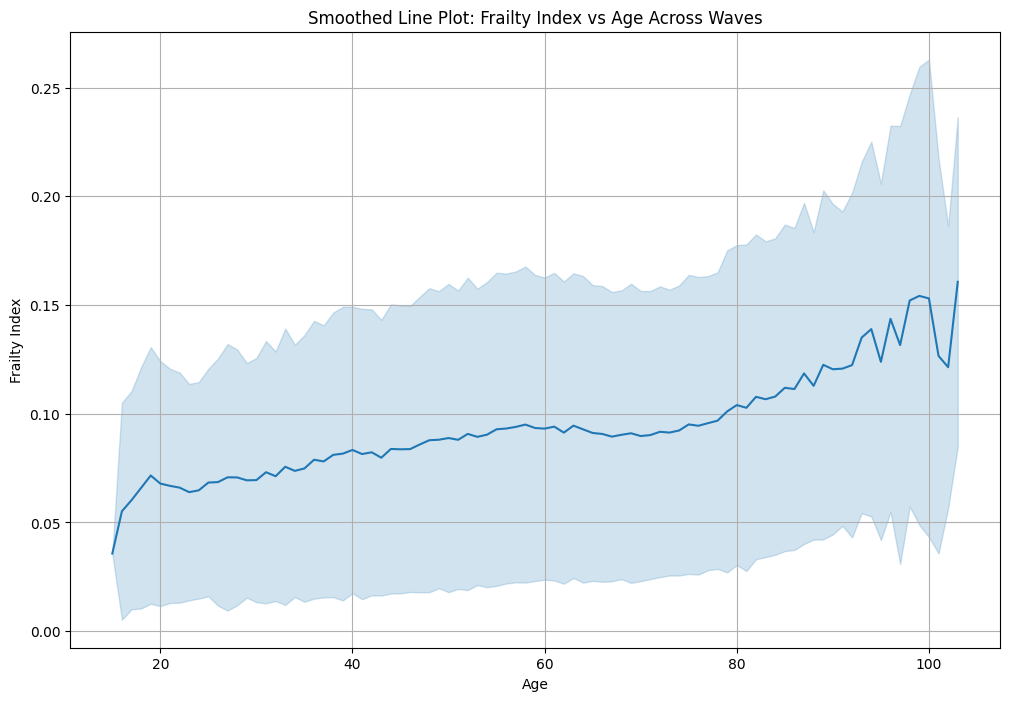

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the frailty index data
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'
frailty_data = pd.read_stata(frailty_index_path)

# Load the cleaned combined data to get the age variables
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'
combined_data = pd.read_stata(cleaned_combined_data_path)

# Define wave prefixes and age column prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]
age_columns = [f'{prefix}_age_dv' for prefix in wave_prefixes]

# Prepare data for the smoothed line plot
scatter_data = pd.DataFrame()

for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    age_col = f'{prefix}_age_dv'
    if frailty_col in frailty_data.columns and age_col in combined_data.columns:
        temp_df = frailty_data[['pidp', frailty_col]].copy()
        temp_age_df = combined_data[['pidp', age_col]].copy()
        temp_df = temp_df.merge(temp_age_df, on='pidp')
        temp_df = temp_df[temp_df[frailty_col] > 0]  # Filter out zero frailty index values
        temp_df['wave'] = prefix
        temp_df = temp_df.rename(columns={frailty_col: 'frailty_index', age_col: 'age'})
        scatter_data = pd.concat([scatter_data, temp_df], ignore_index=True)

# Create smoothed line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd')
plt.xlabel('Age')
plt.ylabel('Frailty Index')
plt.title('Smoothed Line Plot: Frailty Index vs Age Across Waves')
plt.grid(True)
plt.show()
